<p></p>
<p style="font-size: 300%; text-align:center">DFT-LDA Computation of Helium Atom</p>
<hr>
<p style="font-size: 150%; text-align:center">Dongsheng Wen</p>
<p style="font-size: 150%; text-align:center">School of Materials Engineering, Purdue University</p>
<p style="font-size: 150%; text-align:center">wen94@purdue.edu</p>


<hr>

<p style="font-size: 100%"><strong>Abstract. </strong> Though DFT is developed for many electron systems with an aim to lower the computational cost, a hand-on step-by-step calculation of small systems will let learners to take a close look at the science behind the black box. An example for Helium computation by Hartree-Fock Mean Field can be found in ref(1).This notebook implements a DFT-LDA code to calculate the ground state energy of helium atom. This implementation follows the formulations of DFT Helium in Chapter 5 of Thijssen’s book (2), where the main mathematical works and approximations were described. Different from a previous work on Helium calculation(3), which employed combination of basis Gaussian functions, this work will calculate the same system by solving one radial wavefunction. In this program, the numerical calculation incorporates local density approximation (LDA) to approximate the electron density. 

The simulation will mainly contain three main calculations: <strong>(a)</strong> calculation of the radial Schrödinger equation, <strong>(b)</strong> implementing the electrostatic potential (Hartree), and <strong>(c)</strong> incorporating the electron exchange potential. The eigen value and wavefunction is calculated by integrating the wavefunction with Verlet/Numerov's method with fixed boundary conditions. The first few steps cover the above key components in the self-consistent function (SCF) calculation starting from a guess of the initial value of the wave function. All steps are described in detail. The last part performs the iterative SCF calculation until energy convergence is achieved.<p>

<p style="font-size: 100%">
<strong>Instructions/Tutorial. </strong> Follow the notebook step by step, click "Shift+Return" to run each of the code cells. Markdown cells in front of the code cells describe the key formulations. Users can explore the electronic structure of He by changing paramters such as turning on/off the local density approximation. <p>

<hr>

<p style="font-size: 100%"><strong>Use. </strong> Feel free to download this notebook, improve on it, add features and re-deploy it in nanoHUB for the community to use. <p>

<strong> Reference </strong>
<p>(1)    Alejandro Strachan (2017), "Computational Helium," https://nanohub.org/resources/comphe. (DOI: 10.4231/D32R3NZ97). </p>
<p>(2)    Thijssen, J., 2007. Computational physics. Cambridge university press.</p>
<p>(3)    Baseden, K.A. and Tye, J.W., 2014. Introduction to Density Functional Theory: Calculations by Hand on the Helium Atom. Journal of Chemical Education, 91(12), pp.2116-2123.</p>


<strong>Main Formulations. </strong> A  detailed description of the DFT-LDA method for the He atom can be found in Chapter 5 of Computational Physics by J Thijssen. The ground state wave function of the Helium atom is unknown at the beginning but we can solve the wave function by consider the single particle Schrodinger equation (in radial form and use the atomic units to ignore the constants): 


$$ \left[ -\frac{1}{2} \nabla^2 - \frac{2}{r} + {V_H(r) } + V_{x}(r)\right] u(r) = E'u(r) $$

in which 
the radial wave function: $$u(r) = r\phi(r)$$

Hartree Potential: $$ V_H(r) = \int \frac{ n(r') }{\left| r-r'\right|} dr'^3$$

and Exchange Potential: $$ V_x(r) = -\left({\frac{3}{\pi}}\right)^\frac{1}{3} { n(r)^\frac{1}{3}}$$

One can see that the Hartree potential and exchange potential are of functional of electron density:
$$n(r) = \sum_i^2 \phi_i(r)^2 $$

By rearranging the single particle Schrodinger equation, we arrive at the second order derivative of the wave function:
$$  \nabla^2  u(r) = -2\left(E' + \frac{2}{r} - {V_H(r) } - V_{x}(r) \right) u(r) $$

This term can be plug into the Verlet or Numerov Algorithm to solve the wavefunction by integration from very far to the center of the atom:
The Verlet Algorithm is: 
$$u(r+\delta r) = 2u(r) - u(r-\delta r) + \delta r^2 \nabla^2 u(r)$$

The wave function must satisfy some boundary conditions: u(r)=0 when r = 0 or r = max. And the eigen energy must converge within certain tolerance. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [29]:
# define number of integration steps
N = 2001 
# define integration step size, integrate from far positive to 0, so it is negative 
dr = -0.01000000 
# list of dr for integration
dr_l = ones(N)*dr 
hfindex = int(N-1) 
r = zeros(N);
r[0]=(N-1)*abs(dr) 
# define radial distance from far to 0 with step size dr
for i in range(1,N):
    r[i] = dr+r[i-1]

<strong> Step 1: check integration of Schrodinger Equation for Hydrogen Atom Wavefunction. </strong>
<p> Check the wave function integration and the convergence of E for hydrogen atom with simple Schrodinger Equation:</p>
$$ \left[ -\frac{1}{2} \nabla^2 - \frac{2}{r}\right] u(r) = E'u(r) $$

<p> Through out the program, the achieved wave function must be normalized with the following: </p>

$$ 1 = \int u(r)^2 dr = \int \left( r\phi (r) \right)^2 dr$$

<p> The converged eigen value is expected to be 0.5, using the atomic units.</p>
<p> To get the eigen value, false position method is used to narrow down the search step by step:</p>
$$ X_{n+1} = \frac{X_{n}F_{n-1} - X_{n-1}F_{n}}{F_{n-1} - F_{n}} $$
<p> in which the quantity X could be the energy E, evaluated at the boundary (r=0) of function F, such as wave function. </p>
<p> The convergence is considered achieved when the following conditions are satisfied:</p>
$$ \left| X_{n+1}-X_{n} \right| <= tolerance $$
$$ \left| F_{n+1}(r=0)-F_{n}(r=0) \right| <= tolerance $$

<p> Check the next cell to see how this work for Hydrogen: </p>

Eigen Energy: -0.4997422065375935 , Theoretical Value is -0.5


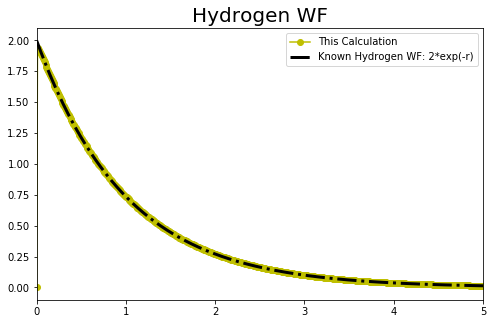

In [32]:
# solve hydrogen atom to check convergence

E1=- 1.9; E3 = -.9# set eigen value initial range (by guessing)
E=E3
ur_hf_old = 1
Z = 1
# solve WF, two conditions
# boundary condition at r = 0
# convergence of eigen energy
while abs(E3-E1)> 1e-11 or abs(ur[hfindex]>1e-10):
    ur=zeros(N);
    #guess of wave function at far distance 
    ur0 = abs(r[0]-dr)*exp(-abs(r[0]-dr));ur1 = abs(r[0])*exp(-abs(r[0]));ur[0] =abs(r[0]-dr)*exp(-abs(r[0]-dr));
    for i in range (1,N):
        # solve wave function u(r) by integration
        ur2 = (2*ur1-ur0+dr**2*2*(-Z/abs(r[i-1])-E)*ur[i-1])
        # update
        ur0 = ur1
        ur1 = ur2
        ur[i] = ur1/(1-dr**2*2*(-Z/abs(r[i])-E))
    # narrow down the search for solution 
    E3 = (E*ur_hf_old-E1*ur[hfindex])/(ur_hf_old-ur[hfindex])
    E1 = E
    E=E3
    ur_hf_old =ur[hfindex]
print('Eigen Energy:', E,', Theoretical Value is -0.5')
# normalization 
ur_norm = ur/sqrt(dot((ur)**2,abs(dr_l)))
R = ur_norm/r
# Check with known Hygrogen WF
ax = plt.figure(figsize=(8,5))
hx = np.linspace(1e-30,20,N)
hy = 2*exp(-hx)
plot(r,R,'o-y',label='This Calculation')
plot(hx,hy,'-.k',linewidth=3,label='Known Hydrogen WF: 2*exp(-r)');
xlim(0,5);title('Hydrogen WF',size=20);
legend();



<strong> The cell below defines the Verlet Algorithm for Hartree Potential as a functional of electron density</strong> 

$$ V_H(r) = \int \frac{ n(r') }{\left| r-r'\right|} dr'^3$$
<p> with the electron density define as: </p>
$$ n(r) = \sum_i^k {\phi_i(r)^2} = \sum_i^k \frac{u_i(r)^2}{r^2} \ ,\ with \ k = 1 $$ 
 <p> the Hartree Potential can be expressed as: </p>  
 $$ \nabla^2 V_H(r) = - 4\pi{rn(r)} $$ 
<p> by using: </p>$$ U_H(r) = rV_H(r)$$
<p> which can be expressed in Poisson equation with respect to the wave function: </p>
$$ \nabla^2 U_H(r) = - \frac{u(r)^2}{r} $$ 
<p> the final expression to update Verlet integration is: </p>
$$U_H(r+\delta r) = 2U_H(r) - U_H(r-\delta r) + \delta r^2 \nabla^2 U_H(r)$$

In [36]:
def U_hartree(U0,U1,ur_i,r_i,dr, A):
    # second order term is the Posson Equation described above
    U2 = 2*U1 - U0 - (dr**2)*(A*ur_i**2)/(abs(r_i))
    return U2 

<strong> Step 2: check the integration of Hartree Potential for the Hydrogen atom</strong>
<p> Again, conditions should be set to regulate the integration of the Poisson Equation to get the Hartree Potential, three conditions must be satisfied:</p>
$$ \left| A_{n+1}-A_{n} \right| <= tolerance $$
<p> in which A is a constant arising from the Hartree Potential integration and should converge to a value that satisfies the boundary conditions below:</p>
$$ U(A,r=max) = q = charge \ of \ the \ electron \ field  $$
$$  U(A,r=0) = 0  $$
<p> And for hunting the solution, differences between subsequent values by false position method should fall within some tolerance </p>
$$ \left| U_{n+1}(r=max)-U_{n}(r=max) \right| <= tolerance $$
$$ \left| U_{n+1}(r=0)-U_{n}(r=0) \right| <= tolerance $$

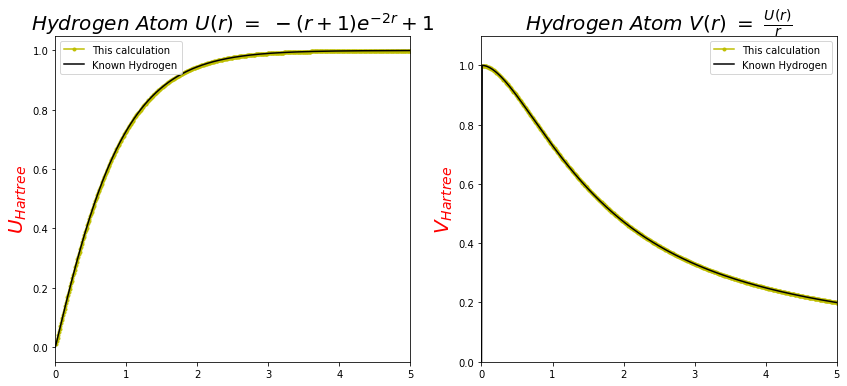

In [37]:
# define integration constant A (guess its range)
A_old=0;A3=1;
A = A3;
U_hf_old=1
# solve Hartree potential 
# # two conditions to check convergence of Hartree 
# integration constant 
# boundary condition of Potential at r=0
while abs(A-A_old)>1e-10 or abs(U_hf_old-0) > 1e-10:
    U = zeros(N);
    U1 = 1; U0 = 1;U[0]=1;
    for i in range (1,N):
        # solve Hartree Potential U(r) by Verlet Algorithm
        U2 = U_hartree(U0,U1,ur_norm[i-1],r[i-1],dr,A) 
        # update
        U0 = U1;
        U1 = U2;
        U[i] = U1
    # narrow down the search for solution with 
    A3 =(A*U_hf_old-A_old*U[hfindex])/(U_hf_old-U[hfindex])
    A_old = A;
    A = A3;
    U_hf_old = U[hfindex]
    
# Hartree Potential V(r)
Vh = U/r

# check the Known Hartree potential for Hydrogen Atom
Uhy = -(hx+1)*exp(-2*hx)+1
Vhy = Uhy/hx
# plot

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax1.plot(r[:-1],U[:-1],'.-y',label = 'This calculation');
ax1.plot(hx,Uhy,'-k',label = 'Known Hydrogen')
ax1.set_ylabel(r'$U_{Hartree}$',color='r',size=20)
ax1.set_xlim(0,5)
plt.title(r'$Hydrogen \ Atom \ U(r) \ = \ -(r+1)e^{-2r}+1 $',size=20)
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(r[:-1],Vh[:-1],'.-y',label = 'This calculation');ax2.set_xlim(0,5)
ax2.plot(hx,Vhy,'-k',label = 'Known Hydrogen')
ax2.set_ylabel(r'$V_{Hartree}$', color='r',size=20);ax2.set_ylim(0,1.1)
plt.title(r'$Hydrogen \ Atom \ V(r) \ = \ \frac{U(r)}{r}$',size=20)
ax2.legend()
plt.show()


<p> Very good agreement has been achieved for Hydrogen.</p>

<strong> <p> Step 3: Combine the above Step 1 and Step 2 and put them in a self-consistent loop to solve Helium atom </p> </strong>

<p> remind that:</p>
<p>    Step 1 integrates Schrodinger to get radial wavefunction: </p>
$$  \nabla^2  u(r) = -2\left(E' + \frac{2}{r} - {V_H(r) } \right) u(r) $$
<p>    Step 2 solve Hartree Potential with the achieved wave function from Step 1</p>
$$ \nabla^2 U_H(r) = - \frac{u(r)^2}{r} $$ 
<p> In the self-consistent loop, the Hartree Potential in Step 2 is plugged in to the Schrodinger equation to solve the eigen energy and eigen function. This is continued until the true eigen energy and wave function are found.</p>


<p> The eigen energy E is related to the total energy by: </p>
$$ E_{tot} = \sum_k E_k' - \int dr V_H(r) u^2(r) \ , \ with \ k = number \ of \ electrons$$

<p> The difference of total energy, Etot, between two subsequent steps should be within set tolerance, which serves as the condition for convergence.</p>

In [39]:
# self-consistent loop 
# initial guess of energy
Etot = 3
Etot_old = 10000
Vh = zeros(N)
ur_new=zeros(N)
ur_new[0]=abs(r[0])*exp(-abs(r[0]));
Z=2 # for Helium atom
count = 1 
while abs(Etot-Etot_old)>1e-5:
# use atomic units
    E1 = -4; E3 = -2;
    #E1=- 1.9; E3 = -.9
    E=E3
    ur_hf_old = 1
        # solve WF, two conditions
    # boundary condition of WF at r = 0
    # convergence of eigen energy
    while abs(E3-E1)> 1e-10 or abs(ur_new[hfindex]>1e-10):
        ur0 = abs(r[0]-dr)*exp(-abs(r[0]-dr));
        ur1 = abs(r[1])*exp(-abs(r[1]));
        ur_new[0]=abs(r[0])*exp(-abs(r[0]));
        ur_new[1]=abs(r[1])*exp(-abs(r[1]));
        for i in range (2,N):
            # Integration 
            ur2 = (2*ur1-ur0+dr**2*2*(-Z/abs(r[i-1])-E+Vh[i-1])*ur_new[i-1])
            # update
            ur0 = ur1
            ur1 = ur2
            ur_new[i] = ur1/(1-(dr**2)*(2*(-Z/abs(r[i-1])-E+Vh[i-1])))
        E3 = (E*ur_hf_old-E1*ur_new[hfindex])/(ur_hf_old-ur_new[hfindex])#E + psi[hfindex]/(d_psi[hfindex])
        E1 = E
        E=E3
        ur_hf_old =ur_new[hfindex]

    A_old=0;A3=2; 
    A = A3;
    U_hf_old=1
    dr_l = ones(N)*dr
    ur_new_norm = ur_new/sqrt(dot(np.multiply(ur_new,ur_new),abs(dr_l)))
    # solve Hartree Potential
    # two conditions to check convergence of Hartree 
    # integration constant
    # boundary condition of Potential at r=0
    while abs(A-A_old)>1e-4 or abs(U_hf_old-0) > 1e-8:
        U = zeros(N);
        # boundary condition at r=max 
        U1 = 1; U0 = 1;U[0]=1;
        for i in range (1,N):
            # Integrate Hartree Potential U(r) by verlet 
            U2 = U_hartree(U0,U1,ur_new_norm[i-1],r[i-1],dr,A) 
            U0 = U1;
            U1 = U2;
            U[i] = U1
        A3 =(A*U_hf_old-A_old*U[hfindex])/(U_hf_old-U[hfindex])
        A_old = A;
        A = A3;
        U_hf_old = U[hfindex]
    
    print('Iteration Count:', count);count+=1;
    # Hartree potential Vh
    Vh = U/r
    Vhintegrant_new = np.multiply(Vh,np.multiply(ur_new_norm,ur_new_norm))
    # Hartree energy
    EVh = dot(Vhintegrant_new[:-1],abs(dr_l[:-1]))
    Etot_old =Etot;
    Etot = 2*E-EVh;
    print('Eigen Energy:', E)
    print('Hartree Energy:', EVh)
    print('Total Energy:', Etot)
    print('----------------------------------------')
print('Converged Eigen Energy:', E)
print('Converged Hartree Energy:', EVh)
print('Converged Total Energy:', Etot)

Iteration Count: 1
Eigen Energy: -1.996497889281978
Hartree Energy: 1.2471958041908597
Total Energy: -5.240191582754816
----------------------------------------
Iteration Count: 2
Eigen Energy: -0.8196941132207295
Hartree Energy: 0.9611077849220204
Total Energy: -2.6004960113634796
----------------------------------------
Iteration Count: 3
Eigen Energy: -0.9493326835308996
Hartree Energy: 1.0424412262211846
Total Energy: -2.941106593282984
----------------------------------------
Iteration Count: 4
Eigen Energy: -0.9074102993335333
Hartree Energy: 1.0184115478348423
Total Energy: -2.833232146501909
----------------------------------------
Iteration Count: 5
Eigen Energy: -0.9193200836211458
Hartree Energy: 1.0254446790622724
Total Energy: -2.8640848463045643
----------------------------------------
Iteration Count: 6
Eigen Energy: -0.9157944823892319
Hartree Energy: 1.023380223108068
Total Energy: -2.8549691878865318
----------------------------------------
Iteration Count: 7
Eigen En

<strong> Discussion </strong>
<p> In this calculation, the converged energy (-2.857) is slightly closer to the experimental data (-2.903) compared to the results solved by 4 basis Gaussian functions, which yields Etot = -2.855 (Thijssen, J., 2007. Computational physics. Cambridge university press). According to Thijssen, with the same technique, the converged total energy, eigen energy, and Hartree energy is -2.861,-0.923, and 1.015, respectively. Slight difference is due to the integration step size (dr) and integration range (r). Despite the differences by algorithm, solving the continuum radial wave function is actually more accurate than solving the basis Gaussian functions because the wave function is not restricted to the combination of Gaussians. From the following plots of wave function and Hartree Potential, the wave function at the core become more reasonable compared to the solution from Gaussians.  

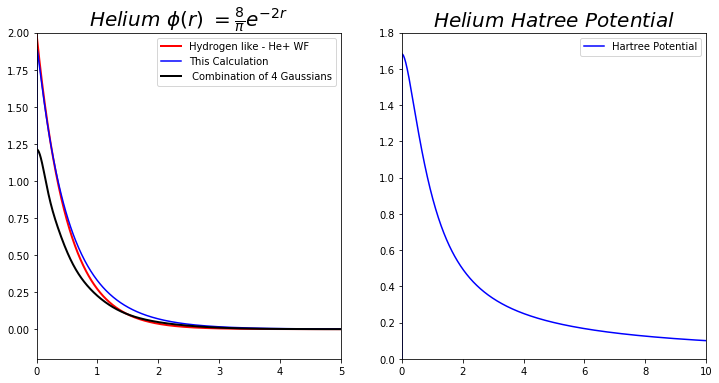

In [10]:
# Plot Hartree-Fock Helium WF
x = np.linspace(1e-20, 10, N);dx = x[2]-x[1];dx_l = ones(N)*dx
y = sqrt(8./np.pi)*exp(-2.*x)
y_norm = y/sqrt(dot((y)**2,dx_l))
yx_norm = y*x/sqrt(dot((y*x)**2,dx_l))
# Gaussian Sollution
C = [0.14691605 , 0.39306002,  0.4111158,   0.26196824]
alpha = [0.297104, 1.236745, 5.749982, 38.216677]

# Plot Helium WF and Hartree Potential from this calculation
R = ur_new_norm/r
R_norm = R/sqrt(dot(R**2,abs(dr_l)))

f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
plt.title(r'$Helium \ \phi(r) \ = \frac{8}{\pi}e^{-2r} $',size=20)
ax2 = f.add_subplot(122)
plt.title(r'$Helium \ Hatree \ Potential $',size=20)

#f.subplots_adjust(hspace=0)
ax1.plot(x,y_norm, linewidth=2, color='red', label='Hydrogen like - He+ WF')
ax1.plot(r,R_norm,color='blue',label='This Calculation');ax1.set_xlim(0,5);ax1.set_ylim(-0.2,2)
ax1.plot(x, abs(C[0]*exp(-1.*alpha[0]*x*x) + C[1]*exp(-1.*alpha[1]*x*x) + C[2]*exp(-1.*alpha[2]*x*x) + C[3]*exp(-1.*alpha[3]*x*x)), linewidth=2, color='k', label=' Combination of 4 Gaussians')
ax2.plot(r,Vh,'b',label='Hartree Potential');ax2.set_xlim(0,10);ax2.set_ylim(0,1.8)
ax1.legend();ax2.legend();

<strong> Step 4: Exchange Potential is considered based on the Self-consistent loop of Step 3. </strong>
<p> Hartree potential is the full electron density, meaning that self-interaction is not considered. The Exchange potential takes into account the influence of this interaction and it is also a functional of the electron density: </p> 
<p> Local Density Approximation (LDA) is used in this program, where the exchange potential can be approximated by a polular form:</p> 

$$ V_x(r) = -\left({\frac{3}{\pi}}\right)^\frac{1}{3} { n(r)^\frac{1}{3}}$$

<p> Again, this potential is added to the Schrodinger equation for solving the eigen energy:</p>
$$ \left[ -\frac{1}{2} \nabla^2 - \frac{2}{r} + 2{V_H(r) } + V_{x}(r)\right] u(r) = E'u(r) $$

$$  \nabla^2  u(r) = -2\left(E' + \frac{2}{r} - 2{V_H(r) } - V_{x}(r) \right) u(r) $$
<p> Step 3 Hartree Potential does not consider self-interaction that a factor of 2 in the Hartree Potential was gone. In this step, exchange potential is added, hoping to correct the self-interaction. Therefore, the factor of 2 comes back in the Hartree Potential. 
<p> then the Total Energy is evaluated by: 
    $$ E_{tot} = \sum_k E' - 2\int dr V_H(r) u^2(r) -\frac{1}{2} \int drV_x(r)u^2(r)\ , \ with \ k = number \ of \ electrons$$

In [40]:
# self-consistent loop + exchange potential
# initial guess of energy 
Etot = 3
Etot_old = 10000
Vh = zeros(N)
Vx = zeros(N)
ur_new=zeros(N)
ur_new[0]=abs(r[0])*exp(-abs(2*r[0])); # guess of WF at r = far, which means phi(r) approching 0
Z=2 # atomic number
count = 1 # count of iteration
# total energy as convergence condition
while abs(Etot-Etot_old)>1e-5:
    # set initial guess of the eigenvalue E, but not the total energy
    E1 = -3; E3 = -2; E=E3
    #E1=-0.8; E3 = -0.4; E=E3
    ur_hf_old = 1
    # solve WF, two conditions
    # boundary condition of WF at r = 0
    # convergence of eigen energy
    while abs(E3-E1)> 1e-10 or abs(ur_new[hfindex]>1e-10):
        ur0 = abs(r[0]-dr)*exp(-abs(r[0]-dr));
        ur1 = abs(r[0])*exp(-abs(r[0]));
        for i in range (2,N):
            # solve wave function psi(r) by integrating numerov
            ur2 = (2*ur1-ur0+(dr**2)*2*(-Z/abs(r[i-1])-E+2*(Vh[i-1])+Vx[i-1])*ur_new[i-1])
            # update
            ur0 = ur1
            ur1 = ur2
            ur_new[i] = ur1/(1-dr**2*2*(-Z/abs(r[i-1])-E+2*(Vh[i-1])+Vx[i-1]))
        E3 = (E*ur_hf_old-E1*ur_new[hfindex])/(ur_hf_old-ur_new[hfindex])#E + psi[hfindex]/(d_psi[hfindex])
        E1 = E
        E=E3
        ur_hf_old =ur_new[hfindex]

    A_old=0;A3=2; 
    A = A3;
    U_hf_old=1
    #normalization
    ur_new_norm = ur_new/sqrt(dot(np.multiply(ur_new,ur_new),abs(dr_l)))
    # solve Hartree Potential
    # two conditions to check convergence of Hartree 
    # integration constant
    # boundary condition of potential at r=0
    while abs(A-A_old)>1e-10 or abs(U_hf_old-0) > 1e-10:
        U = zeros(N);
        U1 = 1; U0 = 1;U[0],U[1]=1,1;
        for i in range (2,N):
            # solve Hartree Potential U(r) by verlet
            U2 = U_hartree(U0,U1,ur_new_norm[i-1],r[i-1],dr,A) 
            U0 = U1;
            U1 = U2;
            U[i] = U1/(1+(dr**2)*(A)/(abs(r[i-1])))
        A3 =(A*U_hf_old-A_old*U[hfindex])/(U_hf_old-U[hfindex])
        A_old = A;
        A = A3;
        U_hf_old = U[hfindex]
    # normalization
    R_norm_new = ur_new_norm/r/sqrt(dot(np.multiply(ur_new_norm/r,ur_new_norm/r),abs(dr_l)));R_norm_new[-1]=R_norm_new[-2]
    # Hartree Potential 
    Vh = U/r;Vh[-1]=Vh[-2] # avoide infinit potential at 0 
    EVh = dot(Vh*ur_new_norm**2,abs(dr_l))
    # Exchange Potential
    Vx = -(3./np.pi)**(1./3) * (ur_new_norm**2./2./np.pi/r**2.)**(1./3);Vx[-1]=Vx[-2]#
    EVx = dot((ur_new_norm)**2*Vx,abs(dr_l))
    Etot_old =Etot;
    Etot = 2*E-2*EVh-EVx/2
    print('Iteration Count:', count);count+=1;
    print('Eigen Energy:', E)
    print('Hartree Energy:', EVh)
    print('Total Energy:', Etot)
    print('----------------------------------------')
print('Converged Eigen Energy:', E)
print('Converged Hartree Energy:', EVh)
print('Converged Total Energy:', Etot)

Iteration Count: 1
Eigen Energy: -1.9964978892819194
Hartree Energy: 1.2469100124885553
Total Energy: -6.130278608313215
----------------------------------------
Iteration Count: 2
Eigen Energy: -0.3213314388288777
Hartree Energy: 0.8656997480104366
Total Energy: -2.1238305656291288
----------------------------------------
Iteration Count: 3
Eigen Energy: -0.6268143227859758
Hartree Energy: 1.0391520567275214
Total Energy: -3.033081192776438
----------------------------------------
Iteration Count: 4
Eigen Energy: -0.4714703421070991
Hartree Energy: 0.9603345976617645
Total Energy: -2.5868158830595913
----------------------------------------
Iteration Count: 5
Eigen Energy: -0.5381355844329764
Hartree Energy: 0.9965207465450928
Total Energy: -2.782383301814587
----------------------------------------
Iteration Count: 6
Eigen Energy: -0.5067623839601869
Hartree Energy: 0.9799544101677344
Total Energy: -2.6911425742303887
----------------------------------------
Iteration Count: 7
Eigen 

<strong> Discussion </strong> 
<p> The eigen energy and total energy is -0.516 and -2.719, very close to the reported values in the Thijssen's book: -0.52 and -2.72. </p>
<p> But the total energy is less accurate than Hartree-Fock in Step 3. This is because the exchange potential approximated by the LDA is crude and Hartree-Fock Mean Field method is superior to LDA in describing the electron-electron interaction with the overlap matrix. </p> 
<p> It is possible to address this by considering the correlation potential, which is described in step 5. </p> 

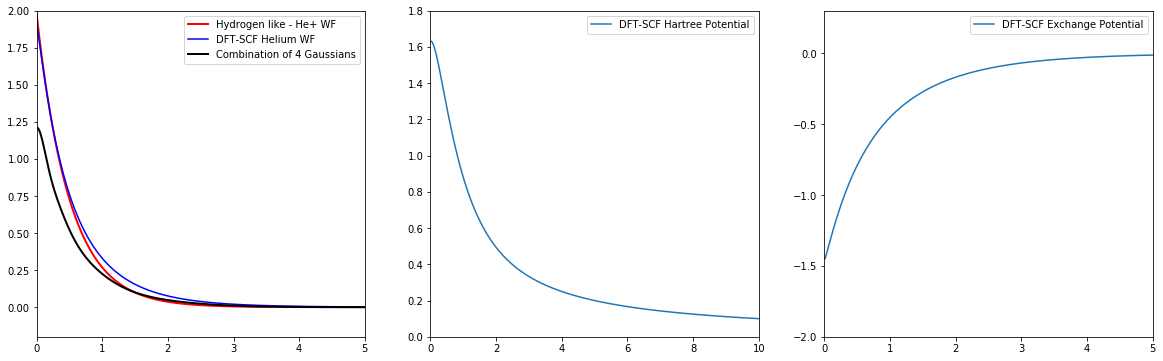

In [41]:
# Helium WF
x = np.linspace(1e-20, 20, N);dx = x[2]-x[1];dx_l = ones(N)*dx
y = sqrt(8./np.pi)*exp(-2.*x)
y_norm = y/sqrt(dot((y)**2,dx_l))
yx_norm = y*x/sqrt(dot((y*x)**2,dx_l))

# Helium WF from this calculation

R = ur_new_norm/r
R_norm = R/sqrt(dot(R[:-1]**2,abs(dr_l[:-1])))

# Helium WF from Gaussians
C = [0.14691605 , 0.39306002,  0.4111158,   0.26196824]
alpha = [0.297104, 1.236745, 5.749982, 38.216677]

f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.plot(x,y_norm, linewidth=2, color='red', label='Hydrogen like - He+ WF')
ax1.plot(r,abs(R_norm_new),label='DFT-SCF Helium WF',color='b');ax1.set_xlim(0,5);ax1.set_ylim(-.2,2)
ax1.plot(x, abs(C[0]*exp(-1.*alpha[0]*x*x) + C[1]*exp(-1.*alpha[1]*x*x) + C[2]*exp(-1.*alpha[2]*x*x) + C[3]*exp(-1.*alpha[3]*x*x)), linewidth=2, color='k', label='Combination of 4 Gaussians')
ax2.plot(r,Vh,label='DFT-SCF Hartree Potential');ax2.set_xlim(0,10);ax2.set_ylim(0,1.8)
ax3.plot(r,Vx,label='DFT-SCF Exchange Potential');ax3.set_xlim(0,5);ax3.set_ylim(-2,0.3)

#ax2.plot(x,yx_norm, linewidth=2, color='red', label='Hydrogen like - He+ WF')
ax1.legend();ax2.legend();ax3.legend();


<strong> Step 5: Consider Correlation. </strong>
<p> By adding the correlation potential to the loop, the result can be refined by using the parameterized correlation potential, Vc, as a functional of electron density:</p>
    $$ V_c(r_s) = \left( 1 - \frac{r_s}{3}\frac{d}{dr_s}\right)\epsilon_c(r_s)$$
<p> in which rs, and epsilon_c is related to the electron density by: </p>
$$ n_s = \frac{3}{4\pi r_s^3}$$
$$ \epsilon_c(r_s) = \gamma \frac{1}{(1+\beta_1 \sqrt{r_s} + \beta_2 r_s)}, \ \ \ when \ r_s \ >= \ 1$$
$$ \epsilon_c(r_s) = A ln(r_s) + B + Cr_sln(r_s) + Dr_s, \ \ \ when \ r_s \ >= \ 1 $$
<p> Vc it is a piecewise function according to the value of rs </p>
$$ V_c(r_s) = \gamma \frac{1+7/6\beta_1\sqrt{r_s}+\beta_2 rs}{(1+\beta_1 \sqrt{r_s} + \beta_2 r_s)^2}, \ \ \ when \ r_s \ >= \ 1$$
$$ V_c(r_s) = A ln(r_s) + B - \frac{A}{3} + \frac{2}{3}Cr_sln(r_s) + \frac{(2D-C)r_s}{3}, \ \ \ when \ r_s \ >= \ 1 $$

<p> For Helium, the parameters are tabulated below for unpolarized case:</p>
$$ A = 0.0311 $$
$$ B = -0.048 $$
$$ C = 0.0020 $$
$$ D = 0.0116 $$
$$ \gamma = -0.1423 $$
$$ \beta_1 = 1.0529 $$
$$ \beta_2 = 0.3334 $$

<p> then the total energy becomes: </p>
 $$ E_{tot} = \sum_k E' - 2\int dr V_H(r) u^2(r) -\frac{1}{2} \int drV_x(r)u^2(r) + \int dr n(r)\epsilon_c(n)n(r) \ , \ with \ k = number \ of \ electrons$$
<p> run the cell below to see how it is improved </p>

In [43]:
# self-consistent loop + exchange potential + correlation potential
Etot = 3
Etot_old = 10000
Vh = zeros(N)
Vx = zeros(N)
ur_new=zeros(N)
ur_new[0]=abs(r[0])*exp(-abs(2*r[0])); # guess of WF at r = far, which means phi(r) approching 0
Z=2 # atomic number
Vc = zeros(N);Ec=0
# parameters in Vc 
Aa = 0.0311;B= -0.048;C= 0.002;D= -0.0116;gamma= -0.1423; beta1= 1.0529; beta2= 0.3334;
count = 1 # count of iteration
# convergence check of total energy
while abs(Etot-Etot_old)>1e-5:
    # set initial guess of the eigenvalue E, but not the total energy
    E1 = -3; E3 = -2; E=E3
    #E1=-0.8; E3 = -0.4; E=E3
    ur_hf_old = 1
    # solve WF, two conditions
    # boundary condition of WF at r = 0
    # convergence of eigen energy
    while abs(E3-E1)> 1e-10 or abs(ur_new[hfindex]>1e-10):
        ur0 = abs(r[0]-dr)*exp(-abs(r[0]-dr));
        ur1 = abs(r[0])*exp(-abs(r[0]));
        for i in range (2,N):
            # solve wave function psi(r)
            ur2 = (2*ur1-ur0+(dr**2)*2*(-Z/abs(r[i-1])-E+2*(Vh[i-1])+Vx[i-1])*ur_new[i-1])
            # update
            ur0 = ur1
            ur1 = ur2
            ur_new[i] = ur1/(1-dr**2*2*(-Z/abs(r[i-1])-E+2*(Vh[i-1])+Vx[i-1]))
        E3 = (E*ur_hf_old-E1*ur_new[hfindex])/(ur_hf_old-ur_new[hfindex])#E + psi[hfindex]/(d_psi[hfindex])
        E1 = E
        E=E3
        ur_hf_old =ur_new[hfindex]

    A_old=0;A3=2; 
    A = A3;
    U_hf_old=1
    # normalization
    ur_new_norm = ur_new/sqrt(dot(np.multiply(ur_new,ur_new),abs(dr_l)))
    # solve Hartree Potential
    # two conditions to check convergence of Hartree 
    # integration constant
    # boundary condition of potential at r=0
    while abs(A-A_old)>1e-10 or abs(U_hf_old-0) > 1e-10:
        U = zeros(N);
        U1 = 1; U0 = 1;U[0],U[1]=1,1;
        for i in range (2,N):
            # solve Hartree Potential U(r)
            U2 = U_hartree(U0,U1,ur_new_norm[i-1],r[i-1],dr,A) 
            U0 = U1;
            U1 = U2;
            U[i] = U1/(1+(dr**2)*(A)/(abs(r[i-1])))
        A3 =(A*U_hf_old-A_old*U[hfindex])/(U_hf_old-U[hfindex])
        A_old = A;
        A = A3;
        U_hf_old = U[hfindex]
    
    R_norm_new = ur_new_norm/r/sqrt(dot(np.multiply(ur_new_norm/r,ur_new_norm/r),abs(dr_l)));R_norm_new[-1]=R_norm_new[-2]
    # Hartree Potential 
    Vh = U/r;Vh[-1]=Vh[-2] # avoide infinit potential at 0 
    EVh = dot(Vh*ur_new_norm**2,abs(dr_l))
    # Exchange Potential
    Vx = -(3./np.pi)**(1./3) * (ur_new_norm**2./2./np.pi/r**2.)**(1./3);Vx[-1]=Vx[-2]#
    EVx = dot((ur_new_norm)**2*Vx,abs(dr_l))
    # Correlation 
    nr = ur_new_norm**2./2./np.pi/r**2.;nr[-1]=nr[-2]
    rs = (3/4/np.pi/nr)**(1/3);
    epc = np.piecewise(rs,[rs<1,rs>=1],
                       [lambda rs: Aa*np.log(rs)+B+C*rs*np.log(rs)+D*rs,
                        lambda rs: gamma/(1+beta1*rs**(1/2)+beta2*rs)])#gamma/(1+beta1*rs**(1/2)+beta2*rs)]
    Vc = np.piecewise(rs, [rs<1,rs>=1], 
                [lambda rs: Aa*np.log(rs)+B-Aa/3+2/3*C*rs*np.log(rs)+(2*D-C)*rs/3,
                 lambda rs: gamma/(1+beta1*rs**(1/2)+beta2*rs)*(1+7/6*beta1*rs**(1/2)+beta2*rs)/(1+beta1*rs**(1/2)+beta2*rs)])

    Ec = dot(nr*epc*nr,abs(dr_l))
    Etot_old =Etot;
    Etot = 2*E-2*EVh-EVx/2+Ec
    print('Iteration Count:', count);count+=1;
    print('Eigen Energy:', E)
    print('Total Energy:', Etot)
    print('----------------------------------------')
print('----------------------------------------')
print('Converged Eigen Energy:', E)
print('Converged Total Energy:', Etot)

/apps/share64/debian7/anaconda/anaconda3-5.1/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/apps/share64/debian7/anaconda/anaconda3-5.1/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply


Iteration Count: 1
Eigen Energy: -1.9964978892819194
Total Energy: -6.3890773238230585
----------------------------------------
Iteration Count: 2
Eigen Energy: -0.3213314388288777
Total Energy: -2.198226943596189
----------------------------------------
Iteration Count: 3
Eigen Energy: -0.6268143227859758
Total Energy: -3.1757620278478695
----------------------------------------
Iteration Count: 4
Eigen Energy: -0.4714703421070991
Total Energy: -2.6948165565301934
----------------------------------------
Iteration Count: 5
Eigen Energy: -0.5381355844329764
Total Energy: -2.905529706694712
----------------------------------------
Iteration Count: 6
Eigen Energy: -0.5067623839601869
Total Energy: -2.8071930535650527
----------------------------------------
Iteration Count: 7
Eigen Energy: -0.5209594263092894
Total Energy: -2.8518730987160974
----------------------------------------
Iteration Count: 8
Eigen Energy: -0.5144147929096717
Total Energy: -2.831313493158664
--------------------

<strong> Discussion </strong>
<p> The converged energy is improved from Step 4 to Step 5, in which the total energy is -2.837, close to the documented value of -2.83 in Thijssen's book. This refinement slightly corrects the exchange potential if you check the following figures. In figure to the right hand side, the exchange potential is slightly changed by the correlation potential, which can be seen in the curve of Exchange-Correlation potential. </p> 

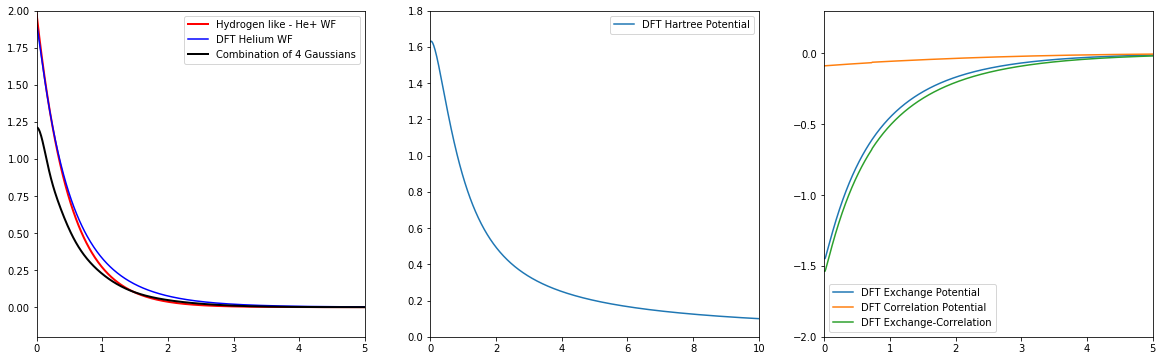

In [44]:
# Helium WF
x = np.linspace(1e-20, 20, N);dx = x[2]-x[1];dx_l = ones(N)*dx
y = sqrt(8./np.pi)*exp(-2.*x)
y_norm = y/sqrt(dot((y)**2,dx_l))
yx_norm = y*x/sqrt(dot((y*x)**2,dx_l))


# Helium WF from this calculation

R = ur_new_norm/r
R_norm = R/sqrt(dot(R[:-1]**2,abs(dr_l[:-1])))
C = [0.14691605 , 0.39306002,  0.4111158,   0.26196824]
alpha = [0.297104, 1.236745, 5.749982, 38.216677]

f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.plot(x,y_norm, linewidth=2, color='red', label='Hydrogen like - He+ WF')
ax1.plot(r,abs(R_norm_new),label='DFT Helium WF',color='b');ax1.set_xlim(0,5);ax1.set_ylim(-.2,2)
ax1.plot(x, abs(C[0]*exp(-1.*alpha[0]*x*x) + C[1]*exp(-1.*alpha[1]*x*x) + C[2]*exp(-1.*alpha[2]*x*x) + C[3]*exp(-1.*alpha[3]*x*x)), linewidth=2, color='k', label='Combination of 4 Gaussians')
ax2.plot(r,Vh,label='DFT Hartree Potential');ax2.set_xlim(0,10);ax2.set_ylim(0,1.8)
ax3.plot(r,Vx,label='DFT Exchange Potential');ax3.set_xlim(0,5);ax3.set_ylim(-2,0.3)
ax3.plot(r,Vc,label='DFT Correlation Potential');
ax3.plot(r,Vc+Vx,label='DFT Exchange-Correlation');
ax1.legend();ax2.legend();ax3.legend();


<strong> Some thoughts on implement the code. </strong>
<p> (a) The integration of continuum wave function yields higher accuracy in obtaining the results and it is more intuitive to understand the calculations behind the Self-consistent loop. The convergence of the calculation, however, is not as fast as solving basis Gaussians. This is because it takes more time to integrate the wave function step by step, and the calculation time scale with the step size and the distance we take. </p>
<p> (b) Poor results were achieved when using the LDA to describe exchange potential. This is because of the crude approximation of LDA in electron density. The paremeterized correlation potential partially corrects the LDA exchange potential and improves the accuracy of the calculation but the results are still less accurate than Hartree-Fock method. On the other hand, to justify the usefulness of LDA, DFT was designed for many-body systems and LDA becomes more valuable when more electrons are considered. </p>
<p> (c) Searching the eigen energy for the system is not intuitive in this program because the False-Position Method is used to pin down the solution. This approach is not as efficient as solving the Hamiltonian matrix. Solving the Hamiltonian matrix yields a spectrum of solutions but False-Position Method can only give one solution at a time by setting the starting range of the Eigen value. If the function oscillates a lot near the solution, it becomes difficult to yield reasonable results. So far the program only calculate the ground state energy of Helium. Users are welcome to change the starting range of eigen energy and search for other solutions of excited states. </p>
